# Sentinel Hub Batch Processing V2

A tutorial about [Large area utilities](./large_area_utilities.ipynb) shows how to split a large area into smaller bounding boxes for which data can be requested using [Sentinel Hub Process API](./process_request.ipynb). This tutorial shows another way of doing that.

**Sentinel Hub Batch Processing** takes the geometry of a large area and divides it according to a specified tile grid. Next, it executes processing requests for each tile in the grid and stores results to a given location at AWS S3 storage. All this is efficiently executed on the server-side. Because of the optimized performance, it is significantly faster than running the same process locally. 

More information about batch processing is available at Sentinel Hub documentation pages:

- [How Batch API works](https://docs.sentinel-hub.com/api/latest/api/batch/)
- [Batch API service description](https://docs.sentinel-hub.com/api/latest/reference/#tag/batch_process)


The tutorial will show a standard process of using Batch Processing with `sentinelhub-py`. The process can be divided into:

1. Define and create a batch request
2. Analyse a batch request before it is executed
3. Run a batch requests job and check the outcome

**Imports**

The tutorial requires packages `geopandas` and `descartes` which are not dependencies of `sentinelhub-py`.

In [1]:
%matplotlib inline

import datetime as dt
import os

import geopandas as gpd

from sentinelhub import (
    CRS,
    BatchProcessClient,
    DataCollection,
    Geometry,
    MimeType,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
    monitor_batch_process_analysis,
    monitor_batch_process_job,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

## 1. Create a batch request

To create a batch request we need to do the following:

- Define a Process API request which we would like to execute on a large area.
- Select a tiling grid which will define how our area will be split into smaller tiles.
- Set up an S3 bucket where results will be saved.


### 1.1 Define a Process API request

First, let's set up the credentials the same way as in [Sentinel Hub Process API tutorial](./process_request.ipynb).

In [2]:
config = SHConfig()

if config.sh_client_id == "" or config.sh_client_secret == "":
    print("Warning! To use Sentinel Hub Process API, please provide the credentials (client ID and client secret).")

For our area of interest, we'll take an area of crop fields in California.

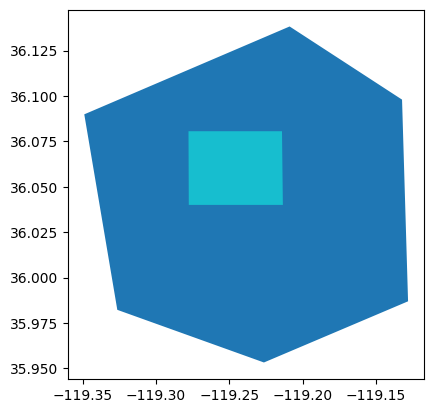

In [3]:
SHAPE_PATH = os.path.join(".", "data", "california_crop_fields.geojson")
area_gdf = gpd.read_file(SHAPE_PATH)

# Geometry of an entire area
full_geometry = Geometry(area_gdf.geometry.values[0], crs=CRS.WGS84)
# Bounding box of a test sub-area
test_bbox = Geometry(area_gdf.geometry.values[1], crs=CRS.WGS84).bbox

area_gdf.plot(column="name");

Let's check a true-color satellite image of the entire area:

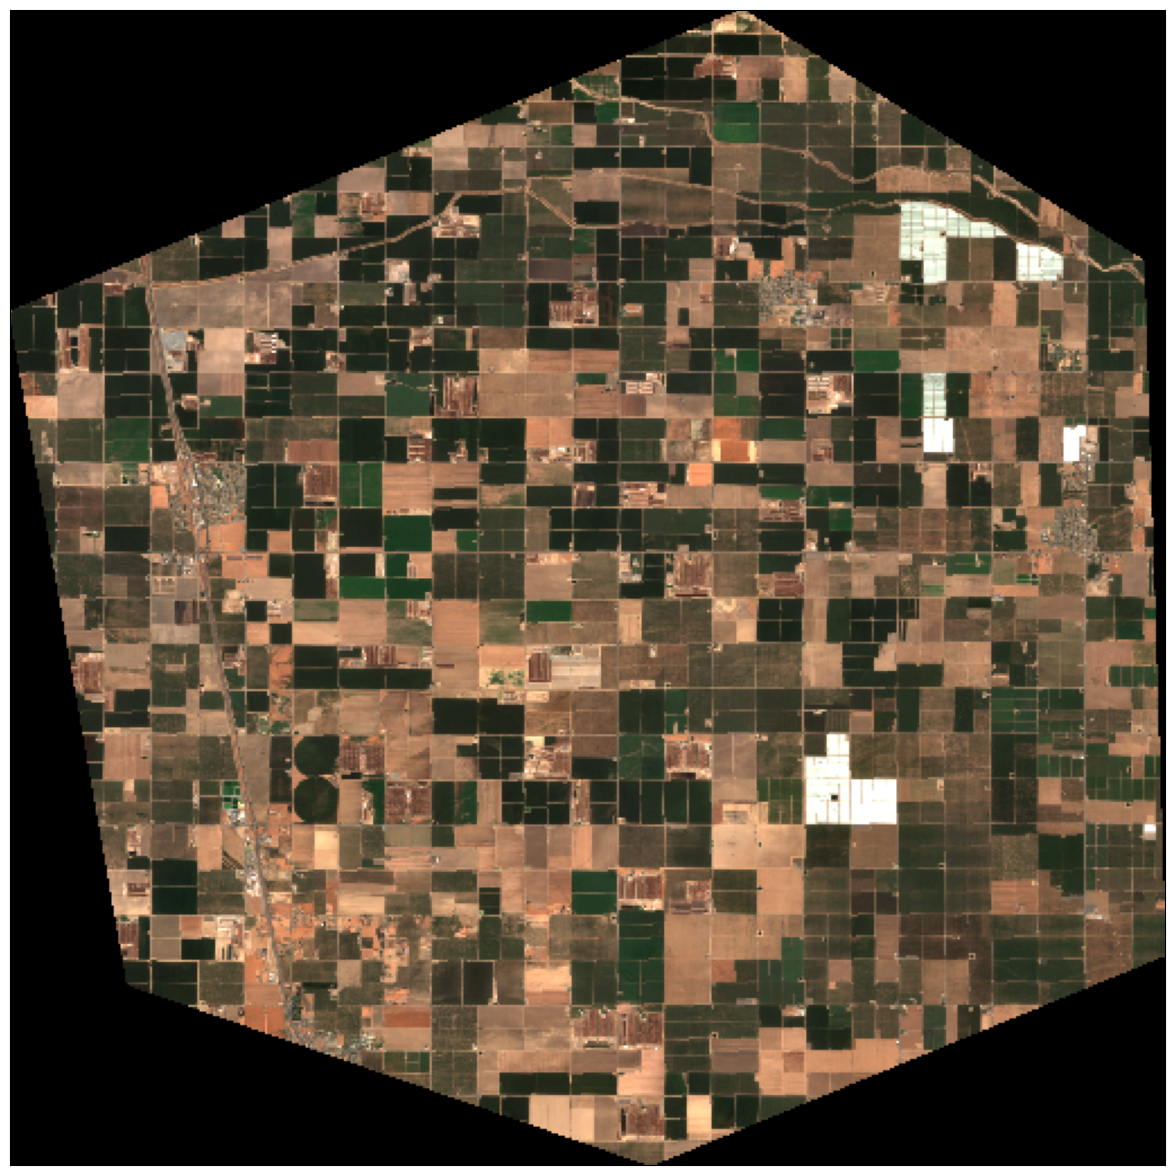

In [4]:
evalscript_true_color = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    geometry=full_geometry,
    size=(512, 512),
    config=config,
)

image = request.get_data()[0]

plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

Next, let's define an evalscript and time range. To better demonstrate the power of batch processing we'll take an evalscript that returns a temporally-interpolated stack NDVI values.

<div class="alert alert-warning">

<b>Warning:</b>
    
In the following cell parameters `evalscript` and `time_interval` are both defined for the same time interval. If you decide to change the time interval you have to change it both in the cell and in the evalscript code.
</div>

In [5]:
EVALSCRIPT_PATH = os.path.join(".", "data", "interpolation_evalscript.js")

with open(EVALSCRIPT_PATH, "r") as fp:
    evalscript = fp.read()

time_interval = dt.date(year=2020, month=7, day=1), dt.date(year=2020, month=7, day=30)

Now we can define a Process API request and test it on a smaller sub-area to make sure we get back desired data.

Output data: ['NDVI.tif', 'data_mask.tif']
CPU times: user 179 ms, sys: 68.8 ms, total: 248 ms
Wall time: 10.4 s


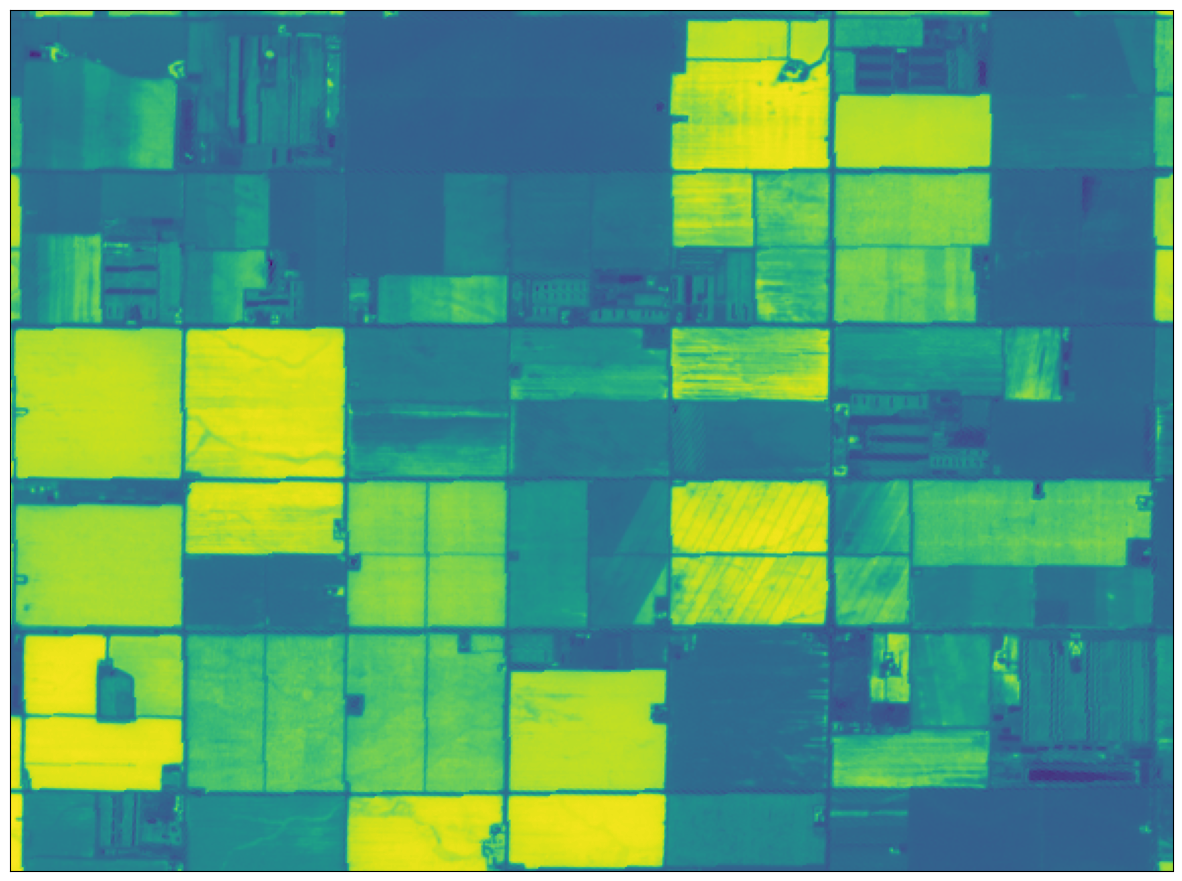

In [6]:
%%time

sentinelhub_request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=time_interval,
        )
    ],
    responses=[
        SentinelHubRequest.output_response("NDVI", MimeType.TIFF),
        SentinelHubRequest.output_response("data_mask", MimeType.TIFF),
    ],
    bbox=test_bbox,
    size=bbox_to_dimensions(test_bbox, 10),
    config=config,
)

results = sentinelhub_request.get_data()[0]

print(f"Output data: {list(results)}")

plot_image(results["NDVI.tif"][..., 2])

We obtained stacks of NDVI values and data masks. 

### 1.2 Define a batch client

The interface for Sentinel Hub Batch API is class `BatchProcessClient`. We initialize it with a configuration object that contains credentials and URLs of the services.

<div class="alert alert-info">

<b>Note:</b>
    
The `BatchProcessClient` interface uses the Version 2 API of batch processing. `SentinelHubBatch` is the client for Version 1.
</div>

In [7]:
client = BatchProcessClient(config=config)

### 1.3 Select a tiling grid

Batch API offers a number of pre-defined tiling grids. We can check which ones are available.

In [8]:
list(client.iter_tiling_grids())

[{'id': 0,
  'name': '20km grid',
  'properties': {'tileWidth': 20040.0,
   'tileHeight': 20040.0,
   'chunkWidth': 334,
   'chunkHeight': 167,
   'resolutions': [10.0, 20.0, 60.0],
   'singleCrs': False,
   'unit': 'METRE'}},
 {'id': 1,
  'name': '10km grid',
  'properties': {'tileWidth': 10000.0,
   'tileHeight': 10000.0,
   'chunkWidth': 500,
   'chunkHeight': 500,
   'resolutions': [1.0, 10.0, 20.0, 1.4999],
   'singleCrs': False,
   'unit': 'METRE'}},
 {'id': 2,
  'name': '100km grid',
  'properties': {'tileWidth': 100080.0,
   'tileHeight': 100080.0,
   'chunkWidth': 278,
   'chunkHeight': 278,
   'resolutions': [360.0, 60.0, 120.0, 240.0],
   'singleCrs': False,
   'unit': 'METRE'}},
 {'id': 3,
  'name': 'WGS84 1 degree grid',
  'properties': {'tileWidth': 1.0,
   'tileHeight': 1.0,
   'chunkWidth': 500,
   'chunkHeight': 500,
   'resolutions': [0.0005, 0.001, 0.002, 0.005, 0.008, 0.0001, 0.0002, 0.0008],
   'singleCrs': True,
   'unit': 'DEGREE'}},
 {'id': 6,
  'name': 'LAEA 10

Let's select a 10km grid, which is based on Sentinel-2 data tiling grid in UTM coordinate reference systems.

There is also an option to check a definition for a single grid:

In [9]:
# Specify grid ID here:
GRID_ID = 1

client.get_tiling_grid(GRID_ID)

{'id': 1,
 'name': '10km grid',
 'properties': {'tileWidth': 10000.0,
  'tileHeight': 10000.0,
  'chunkWidth': 500,
  'chunkHeight': 500,
  'resolutions': [1.0, 10.0, 20.0, 1.4999],
  'singleCrs': False,
  'unit': 'METRE'}}

### 1.4 Set up an S3 bucket

For this step please follow [instructions](https://docs.sentinel-hub.com/api/latest/api/batch/#aws-s3-bucket-settings) on how to configure an S3 bucket in a way that Sentinel Hub service will be able to write to it.

In [17]:
BUCKET_PATH = "???"

ROLE_ARN = "???"

### 1.5 Join batch request definition

Now we are ready to create an entire batch request. This step won't trigger the actual processing. It will only save a batch request definition to the server-side.

In [18]:
sentinelhub_request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=time_interval,
        )
    ],
    responses=[
        SentinelHubRequest.output_response("NDVI", MimeType.TIFF),
        SentinelHubRequest.output_response("data_mask", MimeType.TIFF),
    ],
    geometry=full_geometry,
    # This time we don't specify size parameter
    config=config,
)

batch_request = client.create(
    sentinelhub_request,
    input=client.tiling_grid_input(grid_id=GRID_ID, resolution=10, buffer_x=50, buffer_y=50),
    output=client.raster_output(
        delivery=client.s3_specification(BUCKET_PATH, iam_role_arn=ROLE_ARN, region="eu-central-1")
    ),
    description="sentinelhub-py tutorial batch job",
)

batch_request

{'_REPR_PARAM_NAMES': typing.Sequence[str], 'request_id': <class 'str'>, 'error': typing.Union[str, NoneType], 'status': <enum 'BatchRequestStatus'>, 'request': <class 'dict'>, 'domain_account_id': <class 'str'>, 'user_action': typing.Union[sentinelhub.api.batch.base.BatchUserAction, NoneType], 'user_action_updated': typing.Union[datetime.datetime, NoneType], 'created': typing.Union[datetime.datetime, NoneType], 'completion_percentage': <class 'float'>, 'last_updated': typing.Union[datetime.datetime, NoneType], 'cost_PU': typing.Union[float, NoneType], 'stopped_status_reason': typing.Union[sentinelhub.api.batch.base.StoppedStatusReason, NoneType], 'other_data': typing.Union[~CatchAllVar, NoneType]}
{'_REPR_PARAM_NAMES': typing.Sequence[str], 'request_id': <class 'str'>, 'error': typing.Union[str, NoneType], 'status': <enum 'BatchRequestStatus'>, 'request': <class 'dict'>, 'domain_account_id': <class 'str'>, 'user_action': typing.Union[sentinelhub.api.batch.base.BatchUserAction, NoneTyp

BatchProcessRequest(
  request_id=a5b8b581-c4f9-4e94-a07e-a04f029c0783
  created=2024-09-03 12:58:13.957032+00:00
  status=BatchRequestStatus.CREATED
  completion_percentage=0.0
  user_action=BatchUserAction.NONE
  cost_PU=0.0
  ...
)

A batch request has been successfully created. The information about a request is provided in the form of a `BatchRequest` dataclass object. From the object representation, we can see some of its main properties, such as `status`, which defines the current status of a batch request. 

We can also check its full payload:

At this point you can write down your batch request ID. In case you restart your Python kernel or delete `batch_request` object you can always re-initialize it with the request ID:

In [21]:
# Write your batch_request.request_id here
REQUEST_ID = batch_request.request_id

batch_request_1 = client.get_request(REQUEST_ID)

batch_request_1

{'_REPR_PARAM_NAMES': typing.Sequence[str], 'request_id': <class 'str'>, 'error': typing.Union[str, NoneType], 'status': <enum 'BatchRequestStatus'>, 'request': <class 'dict'>, 'domain_account_id': <class 'str'>, 'user_action': typing.Union[sentinelhub.api.batch.base.BatchUserAction, NoneType], 'user_action_updated': typing.Union[datetime.datetime, NoneType], 'created': typing.Union[datetime.datetime, NoneType], 'completion_percentage': <class 'float'>, 'last_updated': typing.Union[datetime.datetime, NoneType], 'cost_PU': typing.Union[float, NoneType], 'stopped_status_reason': typing.Union[sentinelhub.api.batch.base.StoppedStatusReason, NoneType], 'other_data': typing.Union[~CatchAllVar, NoneType]}
{'_REPR_PARAM_NAMES': typing.Sequence[str], 'request_id': <class 'str'>, 'error': typing.Union[str, NoneType], 'status': <enum 'BatchRequestStatus'>, 'request': <class 'dict'>, 'domain_account_id': <class 'str'>, 'user_action': typing.Union[sentinelhub.api.batch.base.BatchUserAction, NoneTyp

BatchProcessRequest(
  request_id=a5b8b581-c4f9-4e94-a07e-a04f029c0783
  created=2024-09-03 12:58:13.957032+00:00
  status=BatchRequestStatus.CREATED
  completion_percentage=0.0
  user_action=BatchUserAction.NONE
  cost_PU=0.0
  ...
)

## 2. Analyse a batch request

Before we run a batch request job we can check currently defined batch requests and run an analysis to determine the outcome of a batch request. Important information we can obtain from this step are:

- the exact geometries of tiles from a tiling grid that will be processed,
- the number of processing units that a batch job will cost.

Note that this analysis paragraph is optional and is not required to run a batch request job.

### 2.1 Investigate past batch requests

We already have our current batch request definition in `batch_request` variable. However, if we would like to find it again we can search the history of all created batch requests:

In [26]:
for request in client.iter_requests():
    print(request)

{'_REPR_PARAM_NAMES': typing.Sequence[str], 'request_id': <class 'str'>, 'error': typing.Union[str, NoneType], 'status': <enum 'BatchRequestStatus'>, 'request': <class 'dict'>, 'domain_account_id': <class 'str'>, 'user_action': typing.Union[sentinelhub.api.batch.base.BatchUserAction, NoneType], 'user_action_updated': typing.Union[datetime.datetime, NoneType], 'created': typing.Union[datetime.datetime, NoneType], 'completion_percentage': <class 'float'>, 'last_updated': typing.Union[datetime.datetime, NoneType], 'cost_PU': typing.Union[float, NoneType], 'stopped_status_reason': typing.Union[sentinelhub.api.batch.base.StoppedStatusReason, NoneType], 'other_data': typing.Union[~CatchAllVar, NoneType]}
{'_REPR_PARAM_NAMES': typing.Sequence[str], 'request_id': <class 'str'>, 'error': typing.Union[str, NoneType], 'status': <enum 'BatchRequestStatus'>, 'request': <class 'dict'>, 'domain_account_id': <class 'str'>, 'user_action': typing.Union[sentinelhub.api.batch.base.BatchUserAction, NoneTyp

### 2.2 Run an analysis

At the moment we don't have information about tiles or processing units yet. But we can order the service to calculate it.

The following will start the analysis on the server-side:

In [23]:
client.start_analysis(batch_request)

monitor_batch_process_analysis(batch_request, client)

{'_REPR_PARAM_NAMES': typing.Sequence[str], 'request_id': <class 'str'>, 'error': typing.Union[str, NoneType], 'status': <enum 'BatchRequestStatus'>, 'request': <class 'dict'>, 'domain_account_id': <class 'str'>, 'user_action': typing.Union[sentinelhub.api.batch.base.BatchUserAction, NoneType], 'user_action_updated': typing.Union[datetime.datetime, NoneType], 'created': typing.Union[datetime.datetime, NoneType], 'completion_percentage': <class 'float'>, 'last_updated': typing.Union[datetime.datetime, NoneType], 'cost_PU': typing.Union[float, NoneType], 'stopped_status_reason': typing.Union[sentinelhub.api.batch.base.StoppedStatusReason, NoneType], 'other_data': typing.Union[~CatchAllVar, NoneType]}
{'_REPR_PARAM_NAMES': typing.Sequence[str], 'request_id': <class 'str'>, 'error': typing.Union[str, NoneType], 'status': <enum 'BatchRequestStatus'>, 'request': <class 'dict'>, 'domain_account_id': <class 'str'>, 'user_action': typing.Union[sentinelhub.api.batch.base.BatchUserAction, NoneTyp

BatchProcessRequest(
  request_id=a5b8b581-c4f9-4e94-a07e-a04f029c0783
  created=2024-09-03 12:58:13.957032+00:00
  status=BatchRequestStatus.ANALYSIS_DONE
  completion_percentage=0.0
  user_action=BatchUserAction.ANALYSE
  cost_PU=0.0
  ...
)

Depending on the size of our batch request it might take from a few seconds to a few minutes for analysis to finish. To determine if the analysis has finished we have to update batch request info and check the `status` information:

In [29]:
batch_request = client.get_request(batch_request)

batch_request

{'_REPR_PARAM_NAMES': typing.Sequence[str], 'request_id': <class 'str'>, 'error': typing.Union[str, NoneType], 'status': <enum 'BatchRequestStatus'>, 'request': <class 'dict'>, 'domain_account_id': <class 'str'>, 'user_action': typing.Union[sentinelhub.api.batch.base.BatchUserAction, NoneType], 'user_action_updated': typing.Union[datetime.datetime, NoneType], 'created': typing.Union[datetime.datetime, NoneType], 'completion_percentage': <class 'float'>, 'last_updated': typing.Union[datetime.datetime, NoneType], 'cost_PU': typing.Union[float, NoneType], 'stopped_status_reason': typing.Union[sentinelhub.api.batch.base.StoppedStatusReason, NoneType], 'other_data': typing.Union[~CatchAllVar, NoneType]}
{'_REPR_PARAM_NAMES': typing.Sequence[str], 'request_id': <class 'str'>, 'error': typing.Union[str, NoneType], 'status': <enum 'BatchRequestStatus'>, 'request': <class 'dict'>, 'domain_account_id': <class 'str'>, 'user_action': typing.Union[sentinelhub.api.batch.base.BatchUserAction, NoneTyp

BatchProcessRequest(
  request_id=a5b8b581-c4f9-4e94-a07e-a04f029c0783
  created=2024-09-03 12:58:13.957032+00:00
  status=BatchRequestStatus.ANALYSIS_DONE
  completion_percentage=0.0
  user_action=BatchUserAction.ANALYSE
  cost_PU=0.0
  ...
)

## 3. Run a batch request job

Once we decide to run a batch request job we can trigger it with the following:

In [33]:
client.start_job(batch_request)

''

Again we can check if a job has finished by updating batch request info.

In [ ]:
batch_request = client.get_request(batch_request)

batch_request

This package also provides a utility function that monitors batch job execution by periodically checking for status of all tiles and sleeping in between.

In [35]:
monitor_batch_process_job(batch_request, client, sleep_time=60)  # It will update progress every 60 seconds

{'_REPR_PARAM_NAMES': typing.Sequence[str], 'request_id': <class 'str'>, 'error': typing.Union[str, NoneType], 'status': <enum 'BatchRequestStatus'>, 'request': <class 'dict'>, 'domain_account_id': <class 'str'>, 'user_action': typing.Union[sentinelhub.api.batch.base.BatchUserAction, NoneType], 'user_action_updated': typing.Union[datetime.datetime, NoneType], 'created': typing.Union[datetime.datetime, NoneType], 'completion_percentage': <class 'float'>, 'last_updated': typing.Union[datetime.datetime, NoneType], 'cost_PU': typing.Union[float, NoneType], 'stopped_status_reason': typing.Union[sentinelhub.api.batch.base.StoppedStatusReason, NoneType], 'other_data': typing.Union[~CatchAllVar, NoneType]}
{'_REPR_PARAM_NAMES': typing.Sequence[str], 'request_id': <class 'str'>, 'error': typing.Union[str, NoneType], 'status': <enum 'BatchRequestStatus'>, 'request': <class 'dict'>, 'domain_account_id': <class 'str'>, 'user_action': typing.Union[sentinelhub.api.batch.base.BatchUserAction, NoneTyp

Completion percentage:   0%|          | 0.0/100 [00:00<?, ?it/s]

{'_REPR_PARAM_NAMES': typing.Sequence[str], 'request_id': <class 'str'>, 'error': typing.Union[str, NoneType], 'status': <enum 'BatchRequestStatus'>, 'request': <class 'dict'>, 'domain_account_id': <class 'str'>, 'user_action': typing.Union[sentinelhub.api.batch.base.BatchUserAction, NoneType], 'user_action_updated': typing.Union[datetime.datetime, NoneType], 'created': typing.Union[datetime.datetime, NoneType], 'completion_percentage': <class 'float'>, 'last_updated': typing.Union[datetime.datetime, NoneType], 'cost_PU': typing.Union[float, NoneType], 'stopped_status_reason': typing.Union[sentinelhub.api.batch.base.StoppedStatusReason, NoneType], 'other_data': typing.Union[~CatchAllVar, NoneType]}
{'_REPR_PARAM_NAMES': typing.Sequence[str], 'request_id': <class 'str'>, 'error': typing.Union[str, NoneType], 'status': <enum 'BatchRequestStatus'>, 'request': <class 'dict'>, 'domain_account_id': <class 'str'>, 'user_action': typing.Union[sentinelhub.api.batch.base.BatchUserAction, NoneTyp

BatchProcessRequest(
  request_id=a5b8b581-c4f9-4e94-a07e-a04f029c0783
  created=2024-09-03 12:58:13.957032+00:00
  status=BatchRequestStatus.DONE
  completion_percentage=100.0
  user_action=BatchUserAction.START
  cost_PU=100.0
  ...
)

Another option is to check which results have already been saved to the given S3 bucket.

When the job is running we can decide at any time to cancel it. Results that have already been produced will remain on the bucket.

In [ ]:
client.stop_job(batch_request)

In [36]:
batch_request.to_dict()

{'request_id': <class 'str'>, 'request': <class 'dict'>, 'domain_account_id': <class 'str'>, 'status': <enum 'BatchRequestStatus'>, 'error': typing.Union[str, NoneType], 'user_action': typing.Union[sentinelhub.api.batch.base.BatchUserAction, NoneType], 'user_action_updated': typing.Union[datetime.datetime, NoneType], 'created': typing.Union[datetime.datetime, NoneType], 'completion_percentage': <class 'float'>, 'last_updated': typing.Union[datetime.datetime, NoneType], 'cost_PU': typing.Union[float, NoneType], 'stopped_status_reason': typing.Union[sentinelhub.api.batch.base.StoppedStatusReason, NoneType], 'other_data': typing.Union[~CatchAllVar, NoneType]}


{'id': 'a5b8b581-c4f9-4e94-a07e-a04f029c0783',
 'request': {'instanceType': 'normal',
  'processRequest': {'input': {'bounds': {'geometry': {'type': 'MultiPolygon',
      'crs': {'type': 'name',
       'properties': {'name': 'urn:ogc:def:crs:OGC::CRS84'}},
      'coordinates': [[[[-119.2089, 36.1383],
         [-119.1323, 36.098],
         [-119.1282, 35.9869],
         [-119.2264, 35.9532],
         [-119.3263, 35.9822],
         [-119.3488, 36.0899],
         [-119.2089, 36.1383]]]]},
     'properties': {'crs': 'http://www.opengis.net/def/crs/EPSG/0/4326'}},
    'data': [{'dataFilter': {'timeRange': {'from': '2020-07-01T00:00:00Z',
        'to': '2020-07-30T23:59:59Z'},
       'mosaickingOrder': 'mostRecent',
       'maxCloudCoverage': 100.0,
       'previewMode': 'DETAIL'},
      'type': 'S2L1C'}]},
   'output': {'responses': [{'identifier': 'NDVI',
      'format': {'type': 'image/tiff'},
      'logo': False},
     {'identifier': 'data_mask',
      'format': {'type': 'image/tiff'},
